The data contains the actual review texts, some additional information, and ratings on a scale from 1 to 5. The texts are stored in JSON files within the array responses.

In [ ]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:26, 1376.04it/s]


In [ ]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

Let's count the number of reviews for different cities and for different banks.

In [ ]:
df = pd.json_normalize(responses)[['city', 'bank_name', 'author', 'datetime', 'rating_grade', 'title', 'text', 'bank_license', 'num_comments', 'rating_not_checked']]

In [ ]:
df.head()

,city,bank_name,author,datetime,rating_grade,title,text,bank_license,num_comments,rating_not_checked
0,г. Москва,Бинбанк,uhnov1,2015-06-08 12:50:54,NaN,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...,лицензия № 2562,0,False
1,г. Новосибирск,Сбербанк России,Foryou,2015-06-08 11:09:57,NaN,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...,лицензия № 1481,0,False
2,г. Москва,Бинбанк,Vladimir84,2015-06-05 20:14:28,NaN,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...,лицензия № 2562,1,False
3,г. Ставрополь,Сбербанк России,643609,2015-06-05 13:51:01,NaN,Меняют проценты комиссии не предупредив и не ...,Добрый день!! Я открыл расчетный счет в СберБа...,лицензия № 1481,2,False
4,г. Челябинск,ОТП Банк,anfisa-2003,2015-06-05 10:58:12,NaN,Верните денежные средства за страховку,"04.03.2015 г. взяла кредит в вашем банке, заяв...",лицензия № 2766,1,False


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   bank_name           153499 non-null  object 
 2   author              153479 non-null  object 
 3   datetime            153499 non-null  object 
 4   rating_grade        88658 non-null   float64
 5   title               153499 non-null  object 
 6   text                153499 non-null  object 
 7   bank_license        153498 non-null  object 
 8   num_comments        153499 non-null  int64  
 9   rating_not_checked  153499 non-null  bool   
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
city_counts = df['city'].value_counts()

In [ ]:
city_counts

city
г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: count, Length: 5823, dtype: int64

In [ ]:
bank_counts = df['bank_name'].value_counts()

In [ ]:
bank_counts

bank_name
Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: count, Length: 670, dtype: int64

Let's plot histograms of word lengths in characters and in words.

In [ ]:
df['len_ch'] = df['text'].apply(len)

Text(0.5, 1.0, 'Гистограмма длин слов в символах')

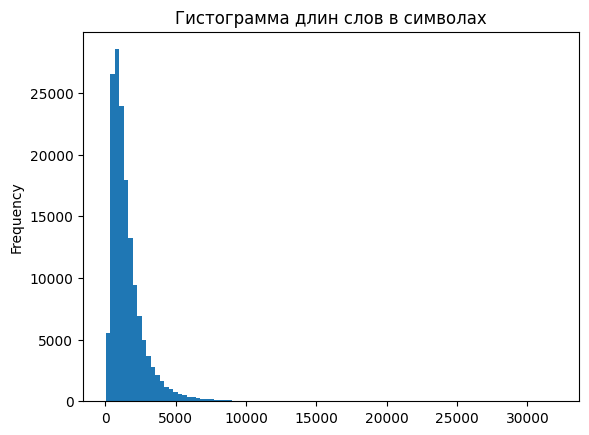

In [ ]:
df['len_ch'].plot(kind = 'hist', bins = 100)
plt.title('Гистограмма длин слов в символах')

In [ ]:
df['len_wo'] = df['text'].apply(lambda x: len(x.split()))

Text(0.5, 1.0, 'Гистограмма длин слов в словах')

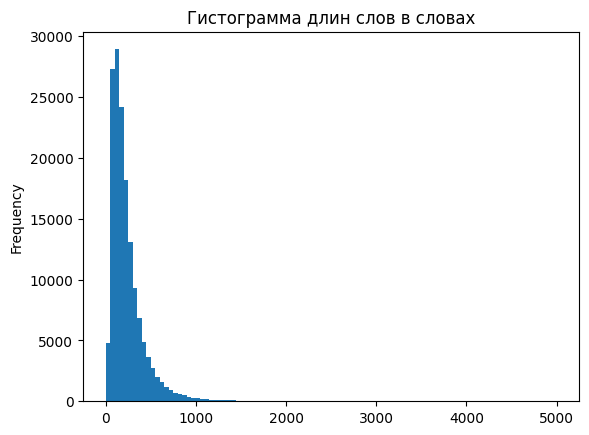

In [ ]:
df['len_wo'].plot(kind = 'hist', bins = 100)
plt.title('Гистограмма длин слов в словах')

Let's find the 10 most frequent: words, words excluding stop words, lemmas, and nouns.

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\S*https?:\S*', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я]', ' ', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:
df['processed_text'] = df['text'][:25000].apply(preprocess_text)

In [ ]:
df['processed_text'].head()

0    добрый день являюсь клиентом банка поручителем...
1    доброго дня являюсь держателем зарплатной карт...
2    здравствуйте дублирую свое заявление можайский...
3    добрый день открыл расчетный счет сбербанке юр...
4    г взяла кредит вашем банке заявленная мною сум...
Name: processed_text, dtype: object

In [ ]:
words = [word for text in df['text'][:25000] for word in word_tokenize(text)]

In [ ]:
word_freq = Counter(words)

In [ ]:
word_freq.most_common(10)

[(',', 456471),
 ('.', 311544),
 ('в', 170051),
 ('и', 141868),
 ('не', 119863),
 ('на', 94047),
 ('что', 85562),
 ('с', 64743),
 ('я', 63422),
 ('по', 52395)]

In [ ]:
words = [word for text in df['processed_text'][:25000] for word in word_tokenize(text)]

In [ ]:
without_stopwords = [word for word in words if word not in stop_words]

In [ ]:
without_stopwords_freq = Counter(without_stopwords)

In [ ]:
without_stopwords_freq.most_common(10)

[('банка', 43496),
 ('банк', 34818),
 ('это', 25370),
 ('деньги', 18928),
 ('карты', 13510),
 ('т', 13169),
 ('карту', 12977),
 ('день', 12241),
 ('г', 11505),
 ('банке', 10923)]

In [ ]:
pip install pymorphy2 pymorphy2-dicts-ru

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 813.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 26.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=6dc229a446787f5f537bc72107ce41b004cb38c30cb31f020b4bb5c1d5993861
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(word):
    return morph.parse(word)[0].normal_form

In [ ]:
lemmas = [lemmatize(word) for word in words]

In [ ]:
lemmas_freq = Counter(lemmas)

In [ ]:
lemmas_freq.most_common(10)

[('банк', 105251),
 ('карта', 43028),
 ('это', 27712),
 ('мой', 25741),
 ('деньга', 25723),
 ('день', 25682),
 ('который', 22561),
 ('сотрудник', 22517),
 ('кредит', 21985),
 ('клиент', 20783)]

In [ ]:
def is_noun(word):
    return morph.parse(word)[0].tag.POS == 'NOUN'

In [ ]:
nouns = [word for word in lemmas if is_noun(word)]

In [ ]:
nouns_freq = Counter(nouns)

In [ ]:
nouns_freq.most_common(10)

[('банк', 105251),
 ('карта', 43028),
 ('деньга', 25723),
 ('день', 25682),
 ('сотрудник', 22517),
 ('кредит', 21985),
 ('клиент', 20783),
 ('отделение', 19043),
 ('счёт', 17655),
 ('сумма', 17292)]

Let's plot the Zipf's law and Heaps' law curves.

In [ ]:
freq_w = Counter(words)

In [ ]:
freqs = list(freq_w.values())

In [ ]:
freqs = sorted(freqs, reverse = True)

Text(0.5, 1.0, 'Кривая Ципфа')

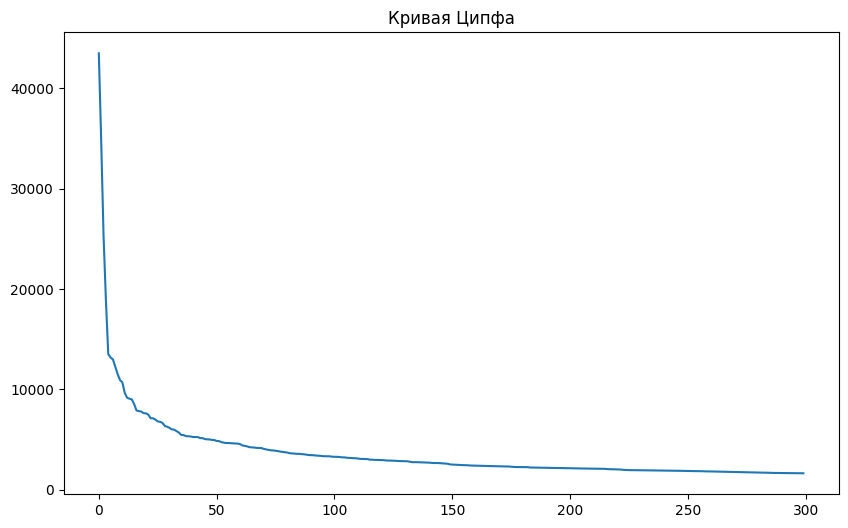

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(freqs[:300])
plt.title('Кривая Ципфа')

In [ ]:
unique_word_counts = []
total_words = 0
unique_words = set()

In [ ]:
for word in words:
    total_words += 1
    unique_words.add(word)
    unique_word_counts.append(len(unique_words))

Text(0.5, 1.0, 'Кривая Хипса')

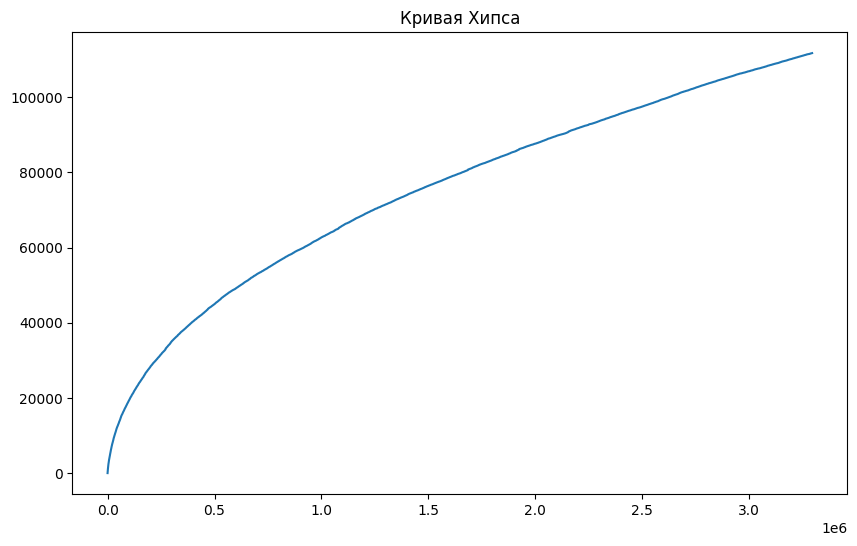

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(total_words), unique_word_counts)
plt.title('Кривая Хипса')

Which word occurs more frequently, 'сотрудник' (worker) or 'клиент' (client)? How many times do the words 'мошенничество' (scam) and 'доверие' (trust) occur?

In [ ]:
worker_count = freq_w['сотрудник']
worker_count

5249

In [ ]:
client_count = freq_w['клиент']
client_count

2717

In [ ]:
scam_count = freq_w['мошенничество']
scam_count

191

In [ ]:
trust_count = freq_w['доверие']
trust_count

196

'Сотрудник' occurs more frequently than 'клиент'. The word 'доверие' appears 196 times, while the word 'мошенничество' appears 191 times.

In the 'rating_grade' field, the review ratings range from 1 to 5. I will use the TF-IDF measure to identify key words and bigrams for positive reviews (with a rating of 5) and negative reviews (with a rating of 1).

In [ ]:
df.dropna(subset=['processed_text'], inplace=True)

In [ ]:
df_positive_responses = df[['processed_text', 'rating_grade']].loc[df['rating_grade'] == 5]

In [ ]:
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
positive_response_1 = TfidfVectorizer()

In [ ]:
bow_positive_1 = positive_response_1.fit_transform(df_positive_responses.processed_text)

In [ ]:
terms = positive_response_1.get_feature_names_out()

In [ ]:
sums = bow_positive_1.sum(axis=0)

In [ ]:
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Слово','Ранг'])
ranking = ranking.sort_values('Ранг', ascending=False)
ranking[:10]

,Слово,Ранг
1026,банка,47.993850
1025,банк,41.665279
14357,очень,36.385791
26229,это,32.369693
2299,вклад,28.313544
22334,спасибо,26.744370
4428,деньги,25.963566
7885,карту,23.518834
1031,банке,23.064917
2887,время,22.564631


In [ ]:
df_negative_responses = df[['processed_text', 'rating_grade']].loc[df['rating_grade'] == 1]

In [ ]:
negative_response_1 = TfidfVectorizer()

In [ ]:
bow_negative_1 = negative_response_1.fit_transform(df_negative_responses.processed_text)

In [ ]:
terms = negative_response_1.get_feature_names_out()

In [ ]:
sums = bow_negative_1.sum(axis=0)

In [ ]:
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Слово','Ранг'])
ranking = ranking.sort_values('Ранг', ascending=False)
ranking[:10]

,Слово,Ранг
2883,банка,248.994450
2882,банк,200.911437
10850,деньги,184.528510
60720,это,163.547071
18739,карту,141.090996
18740,карты,135.274909
16095,заявление,119.999286
32411,отделение,111.439604
20744,кредит,109.942162
10845,день,106.545448


In [ ]:
positive_response_2 = TfidfVectorizer(ngram_range=(2, 2))

In [ ]:
bow_positive_2 = positive_response_2.fit_transform(df_positive_responses.processed_text)

In [ ]:
terms = positive_response_2.get_feature_names_out()

In [ ]:
sums = bow_positive_2.sum(axis=0)

In [ ]:
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг'])
ranking = ranking.sort_values('Ранг', ascending=False)
ranking[:10]

,Биграмма,Ранг
38504,интернет банк,6.142472
27685,добрый день,5.878496
128869,хочу выразить,5.656044
20082,выразить благодарность,5.538397
44008,клиентом банка,5.487553
132868,являюсь клиентом,5.108505
109448,следующий день,4.877534
75909,очень быстро,4.644639
73149,открыть вклад,3.907582
71089,отделение банка,3.896398


In [ ]:
negative_response_2 = TfidfVectorizer(ngram_range=(2, 2))

In [ ]:
bow_negative_2 = negative_response_2.fit_transform(df_negative_responses.processed_text)

In [ ]:
terms = negative_response_2.get_feature_names_out()

In [ ]:
sums = bow_negative_2.sum(axis=0)

In [ ]:
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

ranking = pd.DataFrame(data, columns=['Биграмма','Ранг'])
ranking = ranking.sort_values('Ранг', ascending=False)
ranking[:10]

,Биграмма,Ранг
340439,отделение банка,27.785546
107975,денежных средств,26.742653
107948,денежные средства,26.659064
118219,добрый день,26.387345
91831,горячую линию,24.811084
518946,сих пор,23.140171
91800,горячей линии,22.133957
544345,сотрудник банка,20.238965
545949,сотрудники банка,18.875561
524769,следующий день,17.907483
